# Classification Algorithm Analysis
Notebook to analyze data generated by `classification_algo` in `crawler.py`.

## Setup

In [12]:

import os
import pandas as pd
import json
import statistics
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
from filelock import FileLock
from crawler import CrawlResults
from utils.utils import get_directories, get_domain, split
from utils.image_shingle import ImageShingle
import time
import numpy as np
import math

plt.rcParams.update({'font.size': 16})

CRAWL_NAME = 'KJ2GW'
NUM_WORKERS = 25

DATA_PATH = Path("/usr/project/xtmp/mml66/cookie-classify/") / CRAWL_NAME
ANALYSIS_PATH = Path("analysis") / CRAWL_NAME
FIGURE_PATH = Path("analysis") / CRAWL_NAME / "figs"
FIGURE_PATH.mkdir(parents=True, exist_ok=True)
(ANALYSIS_PATH / "slurm/differences").mkdir(parents=True, exist_ok=True)

# Config
with open(DATA_PATH / "config.yaml", "r") as stream:
    config = yaml.safe_load(stream)

# Site list
site_list = []
with open(config["SITE_LIST_PATH"]) as file:
    for line in file:
        site_list.append(line.strip())

# Site queue
queue_lock = FileLock(config["QUEUE_PATH"] + '.lock', timeout=10)
with queue_lock:
    with open(config["QUEUE_PATH"], 'r') as file:
        site_queue = json.load(file)

# Site results
results_lock = FileLock(config["RESULTS_PATH"] + '.lock', timeout=10)
with results_lock:
    with open(config["RESULTS_PATH"]) as file:
        site_results: dict[str, CrawlResults] = json.load(file)

"""
Check crawl completion.
"""
print(f"Crawled {len(site_results)}/{len(site_list)} sites.")

"""
Reduce the number of sites to analyze.
A successful site must have:
1. a successful domain -> url resolution
3. was not terminated via SIGKILL
2. no unexpected crawl exceptions
"""
successful_sites = []
unsuccessful_sites = []
keys = set()
for domain, result in site_results.items():
    keys.update(result.keys())
    if result.get("url") and not result.get("SIGKILL") and not result.get("unexpected_exception"):
        successful_sites.append(domain)
    else:
        unsuccessful_sites.append(domain)
print(f"{len(successful_sites)} successful sites.")
print(keys)

##############################################################################

Crawled 10000/10000 sites.
7490 successful sites.
{'url', 'unexpected_exception', 'SLURM_ARRAY_TASK_ID', 'SIGKILL', 'data_path', 'traversal_failures', 'total_time', 'landing_page_down', 'clickstream', 'SIGTERM'}


## Unsuccessful sites stats

In [2]:
unsuccessful_sites_stats = {
    "landing_page_down": 0,
    "unexpected_exception": 0,
    "SIGKILL": 0,
    "SIGTERM": 0,
}
for domain in unsuccessful_sites:
    result: CrawlResults = site_results[domain]
    for key in unsuccessful_sites_stats.keys():
        if result.get(key):
            unsuccessful_sites_stats[key] += 1
print(unsuccessful_sites_stats)
print(f"Total unsuccessful sites: {len(unsuccessful_sites)}")

{'landing_page_down': 1897, 'unexpected_exception': 69, 'SIGKILL': 538, 'SIGTERM': 6}
Total unsuccessful sites: 2510


## Successful sites stats

In [3]:
successful_sites_stats = {
    "landing_page_down": 0,
    "SIGTERM": 0,
}
for domain in successful_sites:
    result: CrawlResults = site_results[domain]
    for key in successful_sites_stats.keys():
        if result.get(key):
            successful_sites_stats[key] += 1
print(successful_sites_stats)
print(f"Total unsuccessful sites: {len(successful_sites)}")

{'landing_page_down': 402, 'SIGTERM': 2474}
Total unsuccessful sites: 7490


## Plot Helper Functions

In [4]:
def generate_pie_chart(freq_dict, title=None):
    """
    Generates a pie chart from a frequency dictionary.

    Args:
        freq_dict (dict): A dictionary where keys are categories and values are frequencies.
        title (str): The title of the pie chart. If None, no title is displayed.

    Returns:
        None: Displays the pie chart.
    """
    # Sort the keys alphabetically
    sorted_keys = sorted(freq_dict.keys())

    # Generate a list of distinct colors
    # Note: Increase the number of colors if you have more categories
    colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen', 'lavender', 'orange', 'cyan', 'pink', 'yellowgreen', 'plum']

    # Create a color map by assigning each key a color
    color_map = {key: colors[i % len(colors)] for i, key in enumerate(sorted_keys)}

    # Extract the labels (keys) and sizes (values) from the frequency dictionary
    labels = freq_dict.keys()
    sizes = freq_dict.values()
    
    # Get the list of colors based on the order of labels
    pie_colors = [color_map[label] for label in labels]

    # Generate the pie chart
    plt.figure(figsize=(4, 4))  # Set the figure size
    plt.pie(sizes, labels=labels, colors=pie_colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    
    if title:
        plt.title(title)

    # Display the pie chart
    plt.show()


In [5]:
def get_cdf_df(values: list):
    """
    Returns a dataframe which can be plotted as a CDF graph (see plot_cdf).

    args:
        values: list of values to plot
    """
    s = pd.Series(values, name = 'value')
    df = pd.DataFrame(s)

    # Frequency
    stats_df = df \
    .groupby('value') \
    ['value'] \
    .agg('count') \
    .pipe(pd.DataFrame) \
    .rename(columns = {'value': 'frequency'})

    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

    # CDF
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()

    return stats_df

def plot_cdf(data: dict[str, pd.DataFrame], axis: list):
    """
    Plots multiple CDF graphs on the same axis.

    Args:
        values_list: list of lists, each containing values to plot
        labels: list of labels for the graphs
        axis: axis limits
    """    
    mpl.rcParams.update(mpl.rcParamsDefault)

    for label, values in data.items():
        df = get_cdf_df(values)
        plt.plot(df['value'], df['cdf'], label=label)

    plt.axis(axis)

    plt.xlabel('Value')
    plt.ylabel('CDF')

    plt.grid(visible=True)
    plt.legend()

    plt.show()

def plot_pdf(values: list, label: str, axis: list):
    """
    Plots a PDF graph.

    Args:
        values: list of values to plot
        label: label for the graph
        axis: axis limits
    """    
    mpl.rcParams.update(mpl.rcParamsDefault)

    df = get_cdf_df(values)

    plt.plot(df['value'], df['pdf'], label=label)

    plt.axis(axis)

    plt.xlabel(label)
    plt.ylabel('PDF')

    plt.grid(visible = True)

    plt.show()

### Time

In [6]:
times = []
for site in site_list:
    times.append(site_results[site]["total_time"])
print(f"Median time to crawl a site: {statistics.median(times) / 60} minutes.")
print(f"Total time to crawl all sites: {sum(times) / (60 * 60 * 24)} days.")

Median time to crawl a site: 33.28911415934563 minutes.
Total time to crawl all sites: 241.16966576498967 days.


Per worker

In [7]:
total_time = {}
for domain, result in site_results.items():
    task_id = result["SLURM_ARRAY_TASK_ID"]
    total_time[task_id] = total_time.get(task_id, 0) + (result["total_time"] / (60 * 60))  # convert to hours

# Convert the dictionary into a DataFrame
df = pd.DataFrame(list(total_time.items()), columns=['SLURM_ARRAY_TASK_ID', 'Total_Crawl_Time_Hours'])

# Sort the DataFrame by 'Total_Crawl_Time' in ascending order
df_sorted = df.sort_values(by='Total_Crawl_Time_Hours', ascending=True)

# Display the sorted DataFrame
print(df_sorted.to_string(index=False))

 SLURM_ARRAY_TASK_ID  Total_Crawl_Time_Hours
                  23              145.304312
                  21              204.701099
                  11              212.681529
                  10              222.844431
                   5              225.208150
                  22              225.267816
                   6              226.561962
                  13              227.602922
                  18              228.378706
                  17              228.754127
                  14              231.362431
                   2              231.930466
                  24              234.044887
                  12              237.468044
                   4              238.205619
                  20              238.619806
                  25              239.094777
                   8              241.753448
                   7              242.303032
                   9              242.614804
                  19              244.644743
          

### Clickstream length
Statisistics for both clickstream generation and traversal.

Failed elements clicked by type.
This means we were able to generate the clickstream, but unable to traverse it again.

In [8]:
click_failures = {}

for site in successful_sites:
    for type, failures in site_results[site]['traversal_failures'].items():
        click_failures[type] = click_failures.get(type, 0) + failures

click_failures

{'button': 1831, 'link': 17645, 'onclick': 942, 'pointer': 21340}

Elements clicked by type

In [9]:
from itertools import chain

click_types = {}
for site in successful_sites:
    for _, click_type in list(chain.from_iterable(site_results[site]['clickstream'])):
        click_types[click_type] = click_types.get(click_type, 0) + 1

click_types

{'link': 153585, 'pointer': 128833, 'onclick': 6792, 'button': 23725}

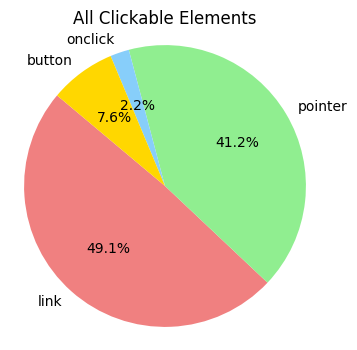

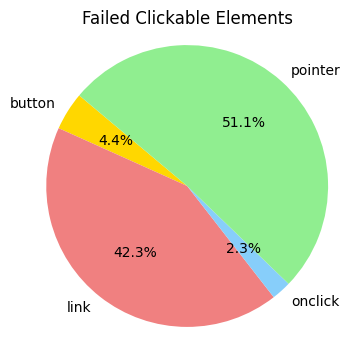

In [10]:
generate_pie_chart(click_types, title="All Clickable Elements")
generate_pie_chart(click_failures, title="Failed Clickable Elements")

Average clickstream length for each group.

- For baseline, this is the average length of the generated clickstream.
- For control and experimental, this is the average length of the successful traversal.

In [27]:
def count_actions(path: Path, name: str) -> int:
    """
    Counts the number of actions in a clickstream by counting the number of images in the directory.
    """    
    count = 0
    while (path / f"{name}-{count+1}.png").is_file():
        count += 1
    return count

In [12]:
def get_average_clickstream_length_per_site() -> pd.DataFrame:
    """
    Returns a dataframe with the average number of actions for each site.
    
    Should not be used to compute the average clickstream length for the entire crawl
    since we cannot take the average of averages.
    """    
    rows_list = []

    for i, domain in enumerate(successful_sites):
        print(f"Processing site {i+1}/{len(successful_sites)}: {domain}")
        clickstreams = get_directories(site_results[domain]["data_path"])

        baseline_actions = []
        control_actions = []
        experimental_actions = []
        for clickstream in clickstreams:
            if (clickstream / f"baseline-0.png").is_file() and \
                (clickstream / f"control-0.png").is_file() and \
                    (clickstream / f"experimental-0.png").is_file():
                baseline_actions.append(count_actions(clickstream, "baseline"))
                control_actions.append(count_actions(clickstream, "control"))
                experimental_actions.append(count_actions(clickstream, "experimental"))

        if len(baseline_actions) == 0 or len(control_actions) == 0 or len(experimental_actions) == 0:
            continue

        rows_list.append({
            "domain": domain,
            "baseline_actions": statistics.mean(baseline_actions),
            "control_actions": statistics.mean(control_actions),
            "experimental_actions": statistics.mean(experimental_actions)
        })

    return pd.DataFrame(rows_list)

clickstream_lengths = get_average_clickstream_length_per_site()
clickstream_lengths['baseline/control'] = clickstream_lengths['baseline_actions'] / clickstream_lengths['control_actions']

# Sort by baseline/control ratio and remove infinities
res = clickstream_lengths.sort_values(by='baseline/control', ascending=False)
res.replace([np.inf, -np.inf], np.nan, inplace=True)
res.dropna(inplace=True)
res

Processing site 1/7490: twitter.com
Processing site 2/7490: icloud.com
Processing site 3/7490: doubleclick.net
Processing site 4/7490: googlevideo.com
Processing site 5/7490: linkedin.com
Processing site 6/7490: google.com
Processing site 7/7490: netflix.com
Processing site 8/7490: cloudflare.com
Processing site 9/7490: wikipedia.org
Processing site 10/7490: fastly.net
Processing site 11/7490: microsoft.com
Processing site 12/7490: gstatic.com
Processing site 13/7490: facebook.com


KeyboardInterrupt: 

In [28]:
def get_all_clickstream_lengths() -> tuple[list, list, list]:
    """
    Returns a tuple of lists containing the lengths of all clickstreams for each type.

    Returns: baseline_actions, controls_actions, experimental_actions
    """
    baseline_actions = []
    control_actions = []
    experimental_actions = []
    for i, domain in enumerate(successful_sites):
        print(f"Processing site {i+1}/{len(successful_sites)}: {domain}")
        
        clickstreams = get_directories(site_results[domain]["data_path"])

        for clickstream in clickstreams:
            # Ensure that we've navigated to the landing page for all three groups
            if (clickstream / f"baseline-0.png").is_file() and \
                    (clickstream / f"control-0.png").is_file() and \
                        (clickstream / f"experimental-0.png").is_file():
                baseline_actions.append(count_actions(clickstream, "baseline"))
                control_actions.append(count_actions(clickstream, "control"))
                experimental_actions.append(count_actions(clickstream, "experimental"))
    
    return baseline_actions, control_actions, experimental_actions

baseline_actions, control_actions, experimental_actions = get_all_clickstream_lengths()

with open(ANALYSIS_PATH / 'baseline_actions.json', 'w') as f:
    json.dump(baseline_actions, f)
with open(ANALYSIS_PATH / 'control_actions.json', 'w') as f:
    json.dump(control_actions, f)
with open(ANALYSIS_PATH / 'experimental_actions.json', 'w') as f:
    json.dump(experimental_actions, f)

Processing site 1/7490: twitter.com
Processing site 2/7490: icloud.com
Processing site 3/7490: doubleclick.net
Processing site 4/7490: googlevideo.com
Processing site 5/7490: linkedin.com
Processing site 6/7490: google.com
Processing site 7/7490: netflix.com
Processing site 8/7490: cloudflare.com
Processing site 9/7490: wikipedia.org
Processing site 10/7490: fastly.net
Processing site 11/7490: microsoft.com
Processing site 12/7490: gstatic.com
Processing site 13/7490: facebook.com
Processing site 14/7490: googleapis.com
Processing site 15/7490: googleusercontent.com
Processing site 16/7490: live.com
Processing site 17/7490: googletagmanager.com
Processing site 18/7490: apple.com
Processing site 19/7490: instagram.com
Processing site 20/7490: office.com
Processing site 21/7490: bing.com
Processing site 22/7490: wordpress.org
Processing site 23/7490: ui.com
Processing site 24/7490: google-analytics.com
Processing site 25/7490: github.com
Processing site 26/7490: fbcdn.net
Processing site

In [2]:
with open(ANALYSIS_PATH / 'baseline_actions.json', 'r') as f:
    baseline_actions = json.load(f)
with open(ANALYSIS_PATH / 'control_actions.json', 'r') as f:
    control_actions = json.load(f)
with open(ANALYSIS_PATH / 'experimental_actions.json', 'r') as f:
    experimental_actions = json.load(f)

Average baseline length: 4.502092294233433
Average control length: 3.411912225705329
Average experimental length: 3.3914995990376906


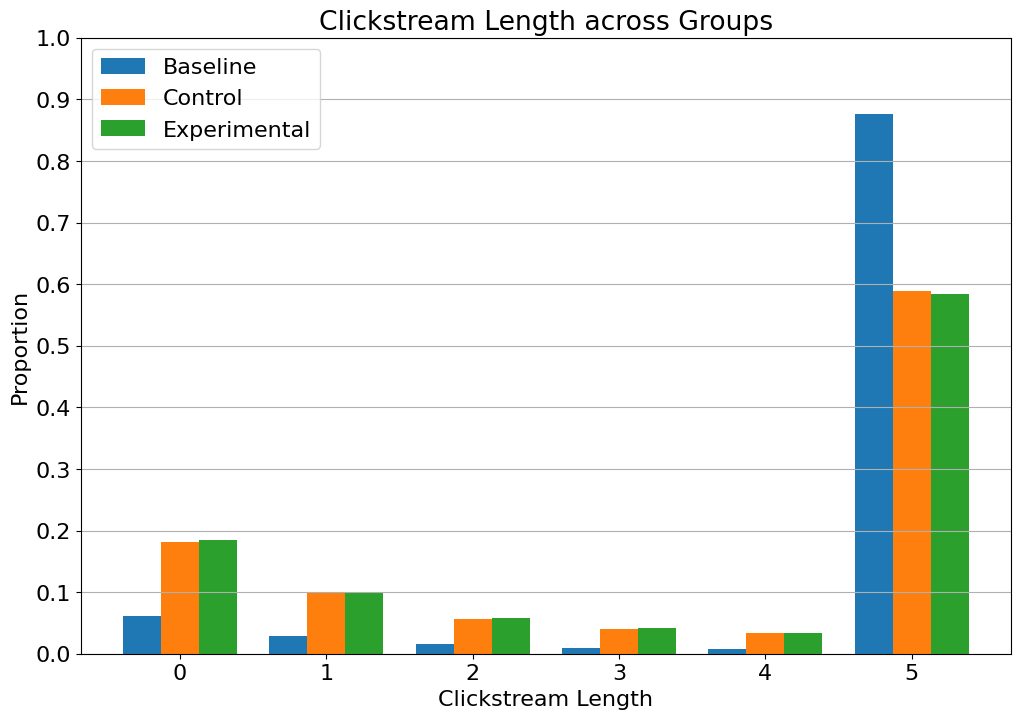

In [23]:
print(f"Average baseline length: {statistics.mean(baseline_actions)}")
print(f"Average control length: {statistics.mean(control_actions)}")
print(f"Average experimental length: {statistics.mean(experimental_actions)}")

def plot_normalized_frequencies(lists_of_numbers, labels):
    """
    Plots the normalized frequencies of numbers as percentages from multiple lists with custom labels,
    with reduced whitespace between each set of bars for a more compact visualization.
    
    Parameters:
    lists_of_numbers (list of list of int): A list containing multiple lists of numbers.
    labels (list of str): A list containing labels for each list of numbers.
    """
    # Initialize an empty list to store normalized frequencies for each list
    all_normalized_frequencies = []

    # Function to calculate frequency
    def calculate_frequency(numbers):
        frequency = {}
        for number in numbers:
            if number in frequency:
                frequency[number] += 1
            else:
                frequency[number] = 1
        return frequency

    # Function to normalize frequency
    def normalize_frequency(frequency):
        total_count = sum(frequency.values())
        return {number: (count / total_count) for number, count in frequency.items()}

    # Calculating and normalizing frequencies for each list
    for numbers_list in lists_of_numbers:
        frequency = calculate_frequency(numbers_list)
        normalized_frequency = normalize_frequency(frequency)
        all_normalized_frequencies.append(normalized_frequency)

    # Combining all numbers from all lists and sorting them
    all_numbers = sorted(set().union(*[frequency.keys() for frequency in all_normalized_frequencies]))

    # Preparing the plot
    plt.figure(figsize=(12, 8))
    # Adjusting the width for reduced whitespace
    width = 0.35
    indices = [x * (1 + width) for x in range(len(all_numbers))]

    for i, normalized_frequency in enumerate(all_normalized_frequencies):
        data = [normalized_frequency.get(number, 0) for number in all_numbers]
        plt.bar([index + (i * width) - (width * len(lists_of_numbers) / 2) + width / 2 for index in indices], data, width=width, label=labels[i] if i < len(labels) else f'List {i+1}')

    plt.xlabel('Clickstream Length')
    plt.ylabel('Proportion')
    plt.ylim(0, 1)
    plt.title('Clickstream Length across Groups')
    plt.yticks(np.arange(0, 1+0.1, 0.1))
    plt.xticks(indices, all_numbers)
    plt.legend()
    plt.grid(axis='y')

    # Showing the plot
    plt.savefig(FIGURE_PATH / 'clickstream-length.png', bbox_inches='tight', dpi=600, facecolor='white')
plot_normalized_frequencies([baseline_actions, control_actions, experimental_actions], ["Baseline", "Control", "Experimental"])

## Analysis

In [15]:
raw_differences = {}
for i in range(NUM_WORKERS):
    with open(ANALYSIS_PATH / f'slurm/differences/{i}.json', 'r') as file:
        to_merge = json.load(file)
    raw_differences.update(to_merge)
print(f"Successful domains analyzed: {len(raw_differences)}/{len(successful_sites)}")

Successful domains analyzed: 1/7490


In [25]:
for domain, clickstreams in raw_differences.items():
    for clickstream, actions in clickstreams.items():
        print(len(actions))

6
6
6
6
6
6
6
6
6


In [22]:
def unravel(data: dict, diff_type: str, add_labels: bool = False) -> tuple[list, dict]:
    """
    Unravel the screenshot differences, filtered by clicksteam depth.

    Args:
        screenshots: The screenshots dictionary. See screenshot_comparison.py for the schema.
        difference_type: The type of difference to unravel.

    Returns:
        Tuple[list, dict]: A tuple containing a list of all the differences and a dictionary containing the differences by clickstream depth.
    """
    # Init
    # Schema: depth -> [domain, difference] | [difference]
    unraveled_raw: dict[int, pd.DataFrame | list] = {}  # Unravel each difference by depth
    unraveled_domains: dict[int, pd.DataFrame | list] = {}  #  # Average differences by domain before unraveling
    for i in list(range(config["CLICKSTREAM_LENGTH"]+1)) + ["ALL"]:
        unraveled_raw[i] = []
        unraveled_domains[i] = []

    # Unravel
    for domain, clickstreams in data.items():
        domain_diffs = {}  # collect all diffs for a given domain by depth
        for clickstream, actions in clickstreams.items():
            for action, diff_dict in actions.items():
                action = int(action)
                
                if diff_type in diff_dict:
                    # Append to domain_diffs
                    domain_diffs[action] = domain_diffs.get(action, []) + [diff_dict[diff_type]]
                    domain_diffs["ALL"] = domain_diffs.get("ALL", []) + [diff_dict[diff_type]]

        # Unravel all diffs into results
        for depth, diffs in domain_diffs.items():
            if add_labels:
                unraveled_raw[depth].extend([{"domain": domain, diff_type: diff} for diff in diffs])
                unraveled_domains[depth].append({"domain": domain, diff_type: statistics.mean(diffs)})
            else:
                unraveled_raw[depth].extend(diffs)
                unraveled_domains[depth].append(statistics.mean(diffs))
                
    # Convert dict to dataframe
    if add_labels:
        for depth, diffs in unraveled_domains.items():
            unraveled_domains[depth] = pd.DataFrame(diffs)
        for depth, diffs in unraveled_raw.items():
            unraveled_raw[depth] = pd.DataFrame(diffs)
        
    return {"unraveled_raw": unraveled_raw, "unraveled_domains": unraveled_domains}

diff_types = ["bce_diff", "shingle_did", "img_did", "innerText_did", "links_did"]

unraveled_raw = {}
for diff_type in diff_types:
    unraveled_raw[diff_type] = unravel(raw_differences, diff_type)["unraveled_domains"]
    
diffs_df = pd.DataFrame(list(successful_sites), columns=['domain'])
for diff_type in diff_types:
    to_merge = unravel(raw_differences, diff_type, add_labels=True)["unraveled_domains"]["ALL"]
    diffs_df = diffs_df.merge(to_merge, on='domain', how='left')
diffs_df

,domain,bce_diff,shingle_did,img_did,innerText_did,links_did
0,twitter.com,0.0,-0.001647,0.0,0.0,0.0
1,icloud.com,NaN,NaN,NaN,NaN,NaN
2,doubleclick.net,NaN,NaN,NaN,NaN,NaN
3,googlevideo.com,NaN,NaN,NaN,NaN,NaN
4,linkedin.com,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
7485,sodresantoro.com.br,NaN,NaN,NaN,NaN,NaN
7486,tvmon.help,NaN,NaN,NaN,NaN,NaN
7487,888scoreonline.net,NaN,NaN,NaN,NaN,NaN
7488,anime-masters.com,NaN,NaN,NaN,NaN,NaN


## Screenshot Difference CDF

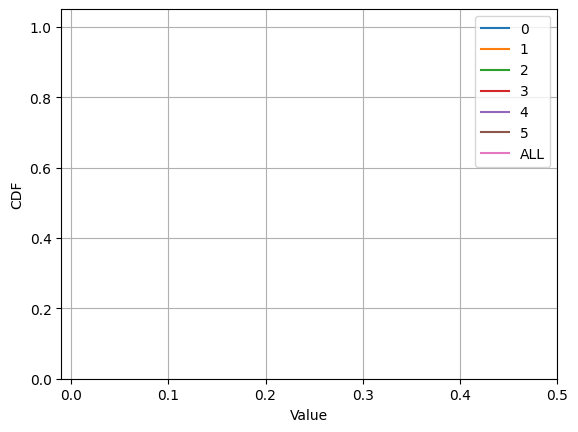

In [23]:
%matplotlib inline
plot_cdf(unraveled_raw['bce_diff'], [-0.01, 0.5, 0, 1.05])

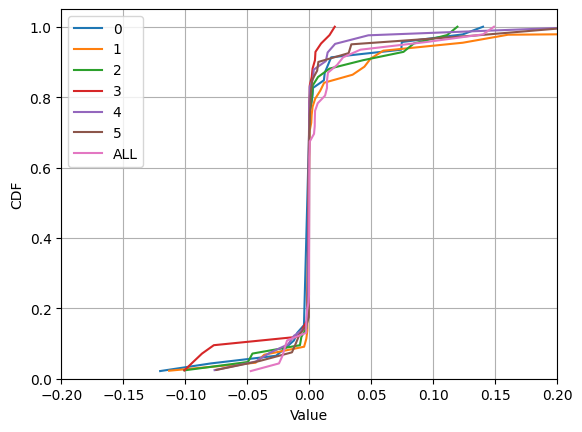

In [38]:
%matplotlib inline
plot_cdf(unraveled_raw['screenshots']['diff_in_diff']['domain_averages'], [-0.2, 0.2, 0, 1.05])

## Features Analysis

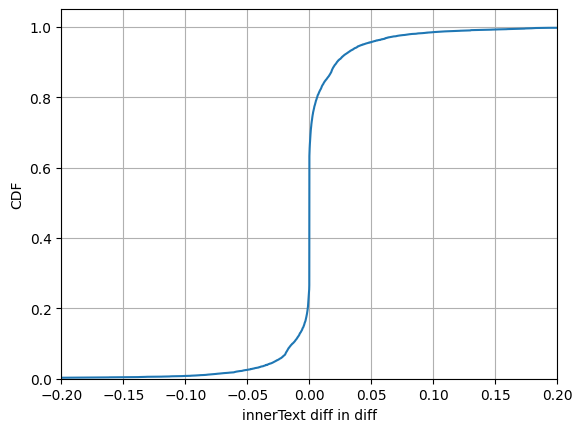

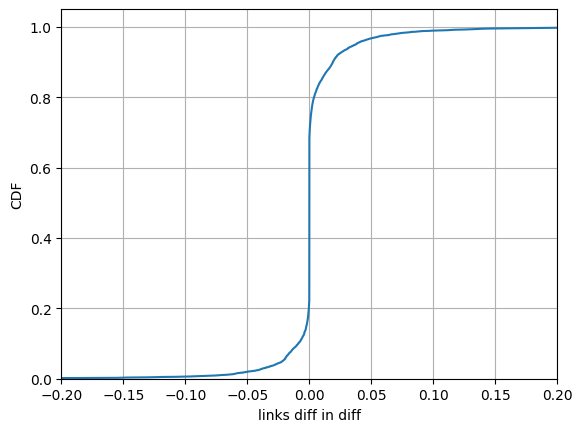

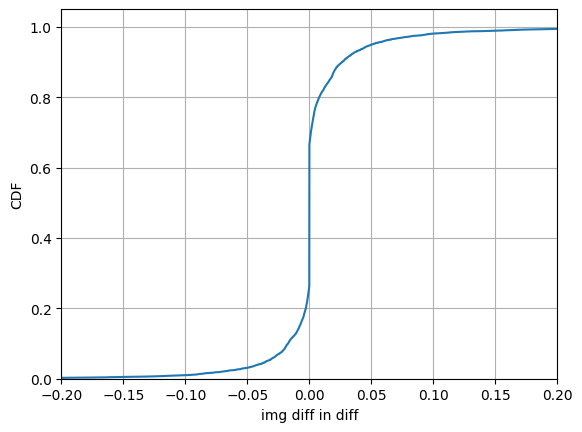

In [9]:
# Difference of Difference
plot_cdf(list(features["innerText"]["diff_in_diff"]), "innerText diff in diff", [-0.2, 0.2, 0, 1.05])
plot_cdf(list(features["links"]["diff_in_diff"]), "links diff in diff", [-0.2, 0.2, 0, 1.05])
plot_cdf(list(features["img"]["diff_in_diff"]), "img diff in diff", [-0.2, 0.2, 0, 1.05])

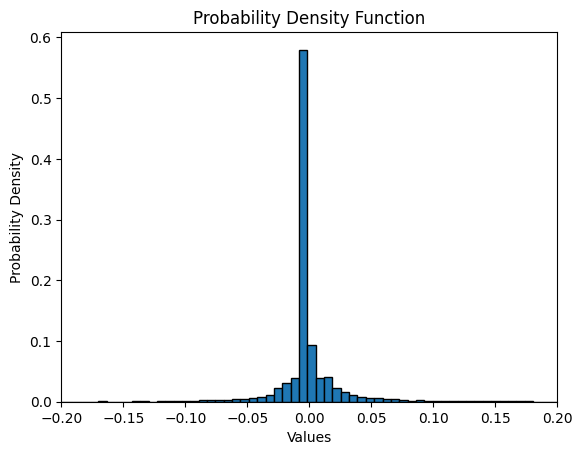

In [34]:
# # Difference of Difference
# plot_pdf(list(features["innerText"]["diff_in_diff"]), "innerText diff in diff", [-1, 1, 0, 1.05])
# plot_pdf(list(features["links"]["diff_in_diff"]), "links diff in diff", [-0.2, 0.2, 0, 1.05])
# plot_pdf(list(features["img"]["diff_in_diff"]), "img diff in diff", [-0.2, 0.2, 0, 1.05])

# Calculate the histogram
hist, bins = np.histogram(list(features["innerText"]["diff_in_diff"]), bins=200, density=True)

# Calculate the PDF
pdf = hist / np.sum(hist)

# Plotting the PDF
plt.bar(bins[:-1], pdf, width=np.diff(bins), edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.title('Probability Density Function')
plt.xlim(-0.2, 0.2) 
plt.show()